## An auto-regressive weather-based linear model

In this notebook, we build a model which uses the previous three years' data to predict the next year's data, along with the previous two years' weather data. We find that beyond what can be predicted based on previous data, the weather data provides a very small or no gain (the residual year-to-year change is very hard to predict). We use the model auto-regressively to predict 2024 based on its 2023 predictions.

In [112]:
import pandas as pd

sub = pd.read_csv('submission/forecast.csv')

# We'll skip the councils without past data
skip_councils = ['Bournemouth', 'City of London', 'Isles of Scilly']
councils = sorted(list(set(sub['Council'].values)))
councils = [c for c in councils if c not in skip_councils]

df_incidence = pd.read_csv('data/FULL-UKHSA-2017-2022-Lyme-Disease.csv')
df_incidence.columns

Index(['Indicator ID', 'Indicator Name', 'Parent Code', 'Parent Name',
       'Area Code', 'Area Name', 'Area Type', 'Sex', 'Age', 'Category Type',
       'Category', 'Time period', 'Value', 'Lower CI 95.0 limit',
       'Upper CI 95.0 limit', 'Lower CI 99.8 limit', 'Upper CI 99.8 limit',
       'Count', 'Denominator', 'Value note', 'Recent Trend',
       'Compared to England value or percentiles', 'Column not used',
       'Time period Sortable', 'New data', 'Compared to goal',
       'Time period range'],
      dtype='object')

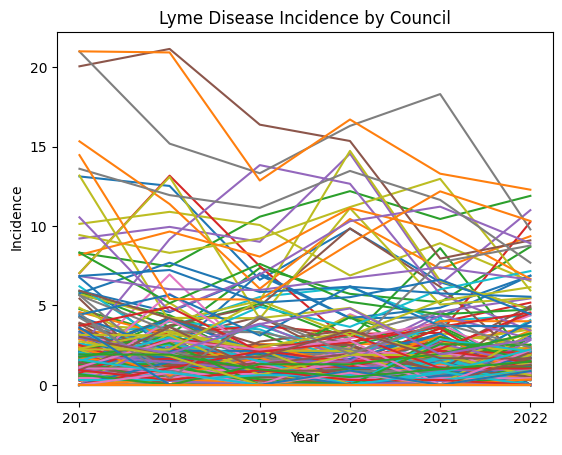

In [4]:
import matplotlib.pyplot as plt
for council in councils:
    df_council = df_incidence[df_incidence['Area Name'] == council]
    plt.plot(df_council['Time period'], df_council['Value'], label=council)
plt.xlabel('Year')
plt.ylabel('Incidence')
_=plt.title("Lyme Disease Incidence by Council")

Text(0.5, 1.0, 'Lyme Disease Incidence by Council, normalized to 2017')

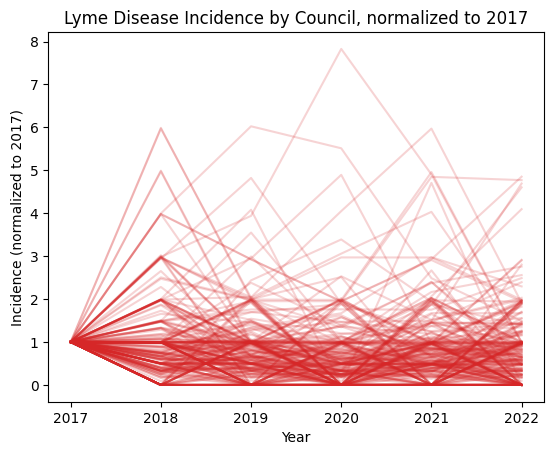

In [5]:
import matplotlib.pyplot as plt
for council in councils:
    df_council = df_incidence[df_incidence['Area Name'] == council]
    plt.plot(df_council['Time period'], df_council['Value'] / df_council['Value'].iloc[0], label=council, alpha=0.2, c='tab:red')
plt.xlabel('Year')
plt.ylabel('Incidence (normalized to 2017)')
plt.title("Lyme Disease Incidence by Council, normalized to 2017")

In [7]:
# Get incidence data for each council for each year
df_clean = pd.DataFrame()
df_clean['councils'] = councils
for yr in [2017, 2018, 2019, 2020, 2021, 2022]:
    data = []
    for council in councils:
        data.append(df_incidence[(df_incidence['Area Name'] == council) & (df_incidence['Time period'] == yr)]['Value'].values[0])
    df_clean[f'{yr}'] = data
df_clean.head()

,councils,2017,2018,2019,2020,2021,2022
0,Adur,1.56934,0.00000,1.54847,0.00000,0.00000,3.09176
1,Amber Valley,3.17718,0.00000,0.79497,0.00000,0.00000,0.00000
2,Arun,5.67262,4.37974,1.83700,4.27713,2.42103,1.80325
3,Ashfield,0.00000,0.00000,0.79038,0.00000,0.79142,0.00000
4,Ashford,1.56830,1.54702,1.53297,0.00000,0.75063,0.00000


## Baseline
We're going to use 2021 and 2022 for evaluation. Let's start by evaluating a baseline of "copy the previous year's data".

In [22]:
import numpy as np
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [10]:
print('Copy previous year, 2022 RMSE:', rmse(df_clean['2022'], df_clean['2021'] * 1.0))
print('Copy previous year, 2021 RMSE:', rmse(df_clean['2021'], df_clean['2020'] * 1.0))

Copy previous year, 2022 RMSE: 1.624119467979275
Copy previous year, 2021 RMSE: 1.6339901729962956


In [11]:
print('Average previous two years, 2022 RMSE:', rmse(df_clean['2022'], (df_clean['2021'] + df_clean['2020']) / 2))
print('Average previous two years, 2021 RMSE:', rmse(df_clean['2021'], (df_clean['2020'] + df_clean['2019']) / 2))

Average previous two years, 2022 RMSE: 1.5679859192584713
Average previous two years, 2021 RMSE: 1.4064367462406329


In [12]:
print('Average all previous years, 2022 RMSE:', rmse(df_clean['2022'], (df_clean['2021'] + df_clean['2020'] + df_clean['2019'] + df_clean['2018'] + df_clean['2017']) / 5))
print('Average all previous years, 2021 RMSE:', rmse(df_clean['2021'], (df_clean['2020'] + df_clean['2019'] + df_clean['2018'] + df_clean['2017']) / 4))

Average all previous years, 2022 RMSE: 1.532197448589307
Average all previous years, 2021 RMSE: 1.4143615096342146


For problems like this, there are likely to be certain councils that have more tick-borne disease than others every year, and so predicting no change from the previous year is likely to be much more effective than random guessing. To zoom into the remaining error, we can reframe the problem as predicting the _residual_ case rate (the change from the previous year).

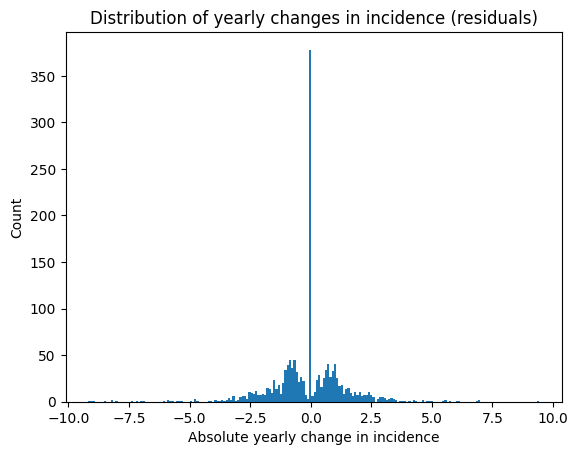

In [8]:
yr_diff = df_clean.iloc[:, 1:].diff(periods=1, axis=1).dropna(axis=1)
plt.hist(yr_diff.values.flatten(), bins=200)
plt.title('Distribution of yearly changes in incidence (residuals)')
plt.xlabel('Absolute yearly change in incidence')
plt.ylabel('Count')
print()

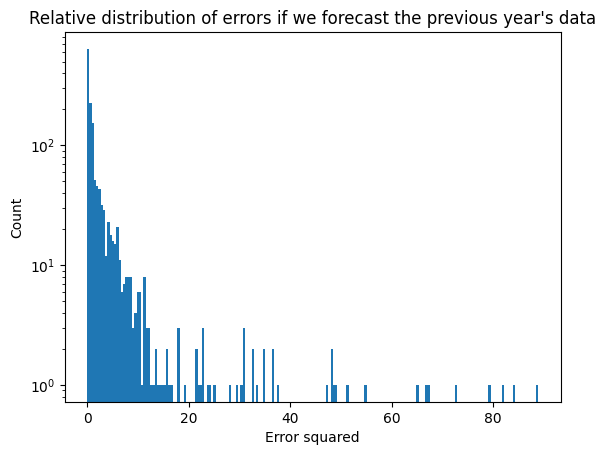

1.645962320390377
1.455850976829117


In [10]:
import numpy as np
plt.hist(yr_diff.values.flatten()**2, bins=200, log=True)
plt.title("Relative distribution of errors if we forecast the previous year's data")
plt.xlabel("Error squared")
plt.ylabel("Count")
plt.show()
errs = yr_diff.values.flatten()**2
print(np.sqrt(errs.mean()))
print(np.sqrt(np.clip(errs, 0, 20).mean()))

Text(0, 0.5, 'Absolute yearly change in incidence')

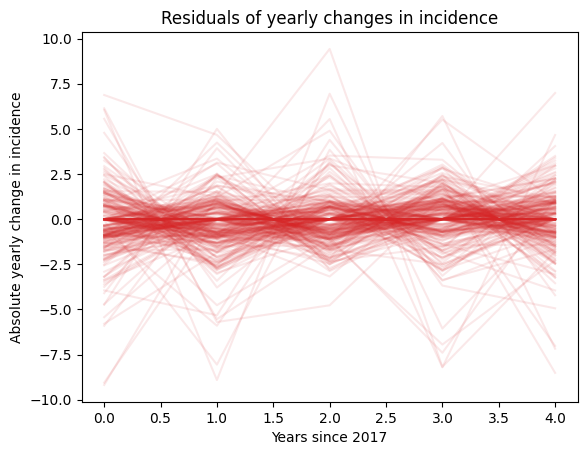

In [12]:
for council, (_, row) in zip(councils, yr_diff.iterrows()):
    plt.plot(row.values, c='tab:red', alpha=0.1)
plt.title('Residuals of yearly changes in incidence')
plt.xlabel('Years since 2017')
plt.ylabel('Absolute yearly change in incidence')

Here, we see the distribution of residuals for each year and council. There are a large number of zero-crossings: councils that have a rise in one year seem to frequently have a fall in the following year. Let's see if we can confirm this by looking at the correlation between the residuals of each year.

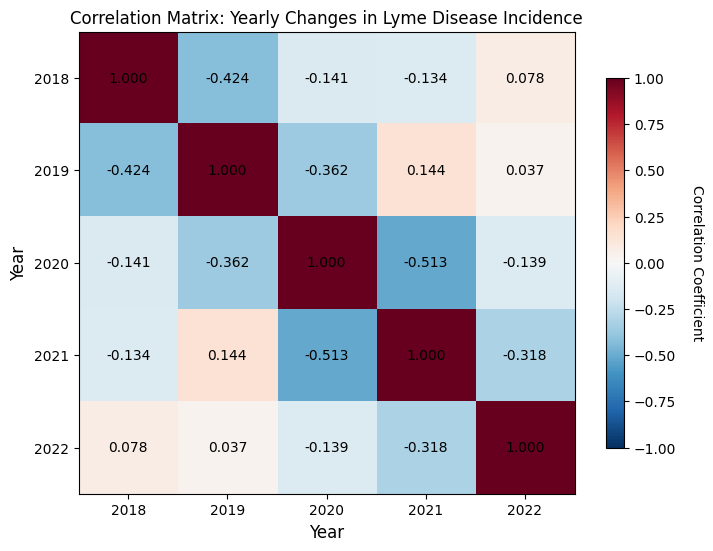

In [19]:
# Calculate correlation matrix for yearly differences
corr_matrix = yr_diff.corr()

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_matrix.values, vmin=-1, vmax=1, cmap='RdBu_r', aspect='auto')

# Set ticks and labels
years = corr_matrix.columns.tolist()
ax.set_xticks(np.arange(len(years)))
ax.set_yticks(np.arange(len(years)))
ax.set_xticklabels(years)
ax.set_yticklabels(years)

# Add correlation values to each cell
for i in range(len(years)):
    for j in range(len(years)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.3f}',
                      ha="center", va="center")

# Customize the plot
ax.set_title('Correlation Matrix: Yearly Changes in Lyme Disease Incidence')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Year', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

So each year's change and the following/previous year's change are quite heavily anti-correlated (30-50%)! This also helps explain why averaging the previous two years' data is a good predictor, as it captures this reversion to the mean.

A simple linear model using multiple previous years' data should also be able to model this behaviour, since we're using linear residuals above.

In [20]:
# Create training and test datasets
# X features: previous two years' data
# y target: current year data

# Training data: Use years 2017-2020 to predict 2019-2021
x_train = []
y_train = []

# 2017, 2018 -> 2019
# We don't have 2016 data so we use 2017 twice in this instance. This is probably better than having less data.
x_train.extend(df_clean[['2017', '2017', '2018']].values)
y_train.extend(df_clean['2019'].values)

# 2018, 2019 -> 2020  
x_train.extend(df_clean[['2017', '2018', '2019']].values)
y_train.extend(df_clean['2020'].values)

# 2019, 2020 -> 2021
x_train.extend(df_clean[['2018', '2019', '2020']].values)
y_train.extend(df_clean['2021'].values)

# Test data: 2020, 2021 -> 2022
x_test = df_clean[['2019', '2020', '2021']].values
y_test = df_clean['2022'].values

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


In [23]:
from sklearn.linear_model import Lasso

lr = Lasso(alpha=0.2)
lr.fit(x_train, y_train)
print(lr.coef_, lr.intercept_)
rmse_val = rmse(y_test, np.clip(lr.predict(x_test), 0, 10))

print(f'Validation RMSE on 2022: {rmse_val}')

[0.16747513 0.20317422 0.44894112] 0.14179083019548155
Validation RMSE on 2022: 1.3331659350214984


Ok, so we've got our RMSE slightly improved again by allowing the linear model to. By using a Lasso model, we bias the model to using as few features as possible (putting as much weight as possible on the last year, effectively), and it still chooses to incorporate

Now, we want to try and bring in some external predictors.

## Historical weather data

The HadUK-Grid dataset is a gridded dataset of historical weather data for the UK. Using local authority boundaries, we can sample weather statistics for each council for each year. This processing is done in `hadgrid_extract_local.py`.

We use the following features aggregated for each year and council:
- `hurs`: Mean relative humidity
- `tas`: Mean temperature
- `tasmax`: Maximum temperature
- `tasmin`: Minimum temperature
- `sun`: Sunshine hours
- `snowLying`: Number of days with snow on the ground
- `groundfrost`: Number of days with ground frost

From this, we provide the model with these seven weather features for the year of prediction and the prior year. This allows the model to also learn _changes_ in weather if it wishes. Where a council hasn't got data, we use the mean of the other councils for that year.

In [26]:
import pandas as pd
df_weather = pd.read_csv('lad_climate_data_2017_2024_extended.csv')
df_weather

,year,council_name,hurs,tasmax,sun,tasmin,tas,snowLying,groundfrost
0,2017,Hartlepool,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,Middlesbrough,80.217383,14.414080,1548.169112,6.893526,10.653735,5.560993,76.071136
2,2017,Redcar and Cleveland,82.347899,14.034711,1570.411241,6.758367,10.400118,7.162544,70.768142
3,2017,Stockton-on-Tees,82.115623,13.724104,1595.166106,5.737830,9.718271,8.323273,97.583275
4,2017,Darlington,81.647887,13.796100,1613.533455,5.924515,9.823995,8.520033,91.630143
...,...,...,...,...,...,...,...,...,...
2947,2020,Somerset UA,83.315476,14.512885,1802.525861,6.801182,10.634786,0.530008,82.123571
2948,2021,Somerset UA,84.624823,13.995618,1620.771517,6.558942,10.259588,4.786035,105.194241
2949,2022,Somerset UA,83.100725,14.999537,1779.319992,6.906043,10.932405,8.416186,88.501577
2950,2023,Somerset UA,85.526979,14.742246,1605.424465,7.424390,11.060005,2.513292,67.752100


In [ ]:
# Create enhanced training dataset with weather variables (COMPACT VERSION)
import numpy as np

weather_vars = ['hurs', 'tasmax', 'sun', 'tasmin', 'tas', 'snowLying', 'groundfrost']

data_configs = [([2017, 2017, 2018], 2019), ([2017, 2018, 2019], 2020), ([2018, 2019, 2020], 2021)]

def create_enhanced_dataset(data_configs, is_training=True):
    """Create enhanced dataset with Lyme + weather features"""
    X, y, councils_with_nan = [], [], set()
    
    # Pre-calculate yearly weather averages for imputation
    all_years = set()
    for config in data_configs:
        if isinstance(config[0], list):
            all_years.update(config[0] + [config[1]])
        else:
            all_years.update(config)
    
    year_means = {yr: df_weather[df_weather['year'] == yr][weather_vars].mean().values 
                  for yr in all_years}
    
    for config in data_configs:
        if isinstance(config[0], list):  # Training format: ([input_years], target_year)
            input_years, target_year = config
        else:  # Test format: [input_years] + target_year
            input_years, target_year = config[:-1], config[-1]
        
        for council in councils:
            # Get Lyme disease data
            lyme_data = [df_clean.loc[df_clean['councils'] == council, str(yr)].values[0] 
                        for yr in input_years]
            
            # Get weather data for prev year and current year
            prev_yr, curr_yr = input_years[-1], target_year
            
            weather_data = []
            for yr in [prev_yr, curr_yr]:
                weather_row = df_weather[(df_weather['council_name'] == council) & 
                                       (df_weather['year'] == yr)]
                if len(weather_row) == 0 or weather_row[weather_vars].isna().any().any():
                    weather_data.extend(year_means[yr])
                    councils_with_nan.add(council)
                else:
                    weather_data.extend(weather_row[weather_vars].values[0])
            
            # Combine features and target
            X.append(lyme_data + weather_data)
            y.append(df_clean.loc[df_clean['councils'] == council, str(target_year)].values[0])
    
    return np.array(X), np.array(y), councils_with_nan

# Create training and test datasets
train_configs = [([2017, 2017, 2018], 2019), ([2017, 2018, 2019], 2020), ([2018, 2019, 2020], 2021)]
# train_configs = [([2017, 2017], 2019), ([2017, 2018], 2020), ([2018, 2019], 2021)]
test_config = [[2019, 2020, 2021, 2022]]

x_train_enhanced, y_train_enhanced, councils_with_nan = create_enhanced_dataset(train_configs)
x_test_enhanced, y_test_enhanced, _ = create_enhanced_dataset(test_config, False)

# Results
print("Councils with missing weather data (imputed with averages):")
print(f"  {', '.join(sorted(councils_with_nan))}")
print(f"\nDataset shapes: Train {x_train_enhanced.shape}, Test {x_test_enhanced.shape}")
print(f"Features: [3 Lyme years, 7 prev weather, 7 curr weather] = 17 total")

# Quick model comparison
lr_original = Lasso(alpha=0.05)
lr_original.fit(x_train_enhanced[:, :3], y_train_enhanced)

lr_enhanced = Lasso(alpha=0.05)
lr_enhanced.fit(x_train_enhanced, y_train_enhanced)

rmse_enhanced = rmse(y_test_enhanced, np.clip(lr_enhanced.predict(x_test_enhanced), 0, 10))
rmse_original = rmse(y_test, np.clip(lr_original.predict(x_test_enhanced[:, :3]), 0, 10))

print(f"\nRMSE: Original {rmse_original:.4f} vs Enhanced {rmse_enhanced:.4f} (Δ{rmse_original-rmse_enhanced:+.4f})")


Councils with missing weather data (imputed with averages):
  Adur, Arun, Blackpool, Fareham, Gosport, Hartlepool, Plymouth, Portsmouth, South Tyneside, Worthing

Dataset shapes: Train (879, 17), Test (293, 17)
Features: [3 Lyme years, 7 prev weather, 7 curr weather] = 17 total

RMSE: Original 1.3375 vs Enhanced 1.3465 (Δ-0.0090)


In [40]:
# Additional analysis of weather variable importance
weather_coef_prev = lr_enhanced.coef_[3:10]
weather_coef_curr = lr_enhanced.coef_[10:17]

print("\nMost influential weather variables:")
combined_importance = [(var, abs(prev) + abs(curr)) 
                      for var, prev, curr in zip(weather_vars, weather_coef_prev, weather_coef_curr)]
for var, importance in sorted(combined_importance, key=lambda x: x[1], reverse=True):
    prev_coef = weather_coef_prev[weather_vars.index(var)]
    curr_coef = weather_coef_curr[weather_vars.index(var)]
    print(f"  {var:11}: Prev={prev_coef:+.3f}, Curr={curr_coef:+.3f}, Total=|{importance:.3f}|")



Most influential weather variables:
  snowLying  : Prev=-0.011, Curr=+0.000, Total=|0.011|
  groundfrost: Prev=-0.005, Curr=+0.004, Total=|0.009|
  sun        : Prev=-0.000, Curr=+0.000, Total=|0.000|
  hurs       : Prev=+0.000, Curr=-0.000, Total=|0.000|
  tasmax     : Prev=+0.000, Curr=+0.000, Total=|0.000|
  tasmin     : Prev=+0.000, Curr=+0.000, Total=|0.000|
  tas        : Prev=+0.000, Curr=+0.000, Total=|0.000|


Unfortunately, the model mostly rejects all the weather features. While the snowLying and groundFrost variables appear useful (each additional day of snow or frost is associated with a 0.01 decrease in lyme disease incidence) it does not appear they are that useful in predicting the change in incidence overall (with a small RMSE increase).

Usually, I'd say that we should therefore take the simpler model for the same RMSE. However, for fun, let's try using the weather data.

# Prediction

I'm going to retrain the linear model with all data (from 2017-2022), and use it to predict 2023. Then, we can run the same model auto-regressively to get 2024 predictions.

In [44]:
train_configs = [([2017, 2017, 2018], 2019), 
                 ([2017, 2018, 2019], 2020), 
                 ([2018, 2019, 2020], 2021),
                 ([2019, 2020, 2021], 2022)]

vars = ['1yr', '2yr', '3yr', 'hurs', 'tasmax', 'sun', 'tasmin', 'tas', 'snowLying', 'groundfrost', 'hurs_1yr', 'tasmax_1yr', 'sun_1yr', 'tasmin_1yr', 'tas_1yr', 'snowLying_1yr', 'groundfrost_1yr']
x_train_all, y_train_all, _ = create_enhanced_dataset(train_configs)

In [50]:
lr_all = Lasso(alpha=0.05)
lr_all.fit(x_train_all, y_train_all)

for var, coef in zip(vars, lr_all.coef_):
    print(f"{var.rjust(15)}: {coef:.3f}")

            1yr: 0.195
            2yr: 0.186
            3yr: 0.439
           hurs: -0.000
         tasmax: 0.000
            sun: -0.000
         tasmin: 0.000
            tas: 0.000
      snowLying: -0.008
    groundfrost: -0.001
       hurs_1yr: -0.000
     tasmax_1yr: 0.000
        sun_1yr: 0.000
     tasmin_1yr: 0.000
        tas_1yr: 0.000
  snowLying_1yr: 0.001
groundfrost_1yr: 0.004


In [60]:
x_2023, _, _ = create_enhanced_dataset([([2020, 2021, 2022], 2022)])
p_2023 = np.clip(lr_all.predict(x_2023), 0, 20)

In [121]:
# Now, to predict 2024, we add these 2023 predictions as ground truth
df_clean['2023'] = p_2023

In [68]:
x_2024, _, _ = create_enhanced_dataset([([2021, 2022, 2023], 2023)])
p_2024 = np.clip(lr_all.predict(x_2024), 0, 20)
df_clean['2024'] = p_2024

In [69]:
df_clean.head(n=10)

,councils,2017,2018,2019,2020,2021,2022,2023,2024
0,Adur,1.56934,0.00000,1.54847,0.00000,0.00000,3.09176,1.512799,1.418868
1,Amber Valley,3.17718,0.00000,0.79497,0.00000,0.00000,0.00000,0.135457,0.184830
2,Arun,5.67262,4.37974,1.83700,4.27713,2.42103,1.80325,2.229817,1.965100
3,Ashfield,0.00000,0.00000,0.79038,0.00000,0.79142,0.00000,0.289456,0.419404
4,Ashford,1.56830,1.54702,1.53297,0.00000,0.75063,0.00000,0.288800,0.439240
5,Babergh,0.00000,0.00000,0.00000,0.00000,1.07847,1.06070,0.721376,0.831150
6,Barking and Dagenham,1.89834,0.47170,0.91396,0.91230,0.91444,0.45456,0.626899,0.685205
7,Barnet,1.28931,1.53007,1.79216,0.76717,1.02840,1.02801,0.887515,0.945674
8,Barnsley,1.64378,1.63133,0.82116,0.40950,1.22506,0.00000,0.427121,0.580025
9,Basildon,1.08413,1.07607,0.00000,0.53249,1.06543,1.05905,0.836137,0.901049


In [77]:
# Average incidence per-year (last two years are predicted). Looks reasonable to me.
df_clean.iloc[:, 1:].mean(axis=0)

2017    2.196179
2018    1.975368
2019    1.682059
2020    1.647638
2021    1.733075
2022    1.695583
2023    1.527876
2024    1.488619
dtype: float64

In [120]:
def get_uncertainty(year, council):
    row = df_incidence.loc[(df_incidence['Area Name'] == council) & (df_incidence['Time period'] == year)]
    if not len(row):
        print(year, council)
    value = row['Value'].values[0]
    ci_low = row['Lower CI 95.0 limit'].values[0]
    ci_high = row['Upper CI 95.0 limit'].values[0]
    return ci_low - value, ci_high - value

df_forecast = pd.read_csv('submission/forecast_base.csv')
for index, row in df_forecast.iterrows():
    if row['Council'] in skip_councils:
        print('Skipping', row['Council'])
        continue
    # Get relevant prediction
    pred = df_clean.loc[df_clean.councils == row['Council'], str(row['Year'])]
    # Since our prediction is almost entirely based on previous data, we use the uncertainties from that source data.
    # This carries over the epistemic certainty (our error in the underlying measurements), but NOT the aleatoric uncertainty (the error due to prediction). You'd want to be more rigorous if relying on these confidence intervals for forecasting.
    low_mult, high_mult = get_uncertainty(2022, row['Council'])
    low_pred = pred + low_mult
    high_pred = pred + high_mult

    df_forecast.at[index, 'Incidence'] = pred
    df_forecast.at[index, 'Lower_95CI'] = low_pred
    df_forecast.at[index, 'Upper_95CI'] = high_pred

df_forecast.to_csv('submission/forecast.csv', index=False)

C:\Users\mikel\AppData\Local\Temp\ipykernel_41240\1628812106.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_forecast.at[index, 'Incidence'] = pred
C:\Users\mikel\AppData\Local\Temp\ipykernel_41240\1628812106.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_forecast.at[index, 'Lower_95CI'] = low_pred
C:\Users\mikel\AppData\Local\Temp\ipykernel_41240\1628812106.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_forecast.at[index, 'Upper_95CI'] = high_pred


Skipping Bournemouth
Skipping City of London
Skipping Isles of Scilly
Skipping Bournemouth
Skipping City of London
Skipping Isles of Scilly
